# Dynamic Network Modules

## Summary

*__Introduction__*

  * Functional organization of the brain is modular. That is, brain regions are organized into functional domains, in which they are strongly connected to each other and weakly connected to brain regions in different functional domains. Modular organization can aid a network in distributing metabolic resources more efficiently amongst nodes.
  
  * The modular organization of a network can change dynamically, perhaps to adapt to changes in network topology. Dynamic reorganization of functinoal brain modules has been associated with ageing, learning, and neurological and psychiatrical diseases.
  
  * Functional brain modules during resting state...
  
*__References__*
  - Bassett, D. S., Wymbs, N. F., Porter, M. A., Mucha, P. J., Carlson, J. M., & Grafton, S. T. (2010). Dynamic reconfiguration of human brain networks during learning. Learning, 108(18), 19. http://doi.org/10.1073/pnas.1018985108
  - Bassett, D. S., Wymbs, N. F., Rombach, M. P., Porter, M. A., Mucha, P. J., & Grafton, S. T. (2013). Task-based core-periphery organization of human brain dynamics. PLoS Computational Biology, 9(9), e1003171. http://doi.org/10.1371/journal.pcbi.1003171.
  - Bassett, D. S., Yang, M., Wymbs, N. F., & Grafton, S. T. (2015). Learning-Induced Autonomy of Sensorimotor Systems. Nature Neuroscience, 18(5), 744–751. http://doi.org/10.1038/nn.3993
  - Sporns, Betzel papers

## Methodology

*__Dynamic Community Detection__*

  * Static and dynamic community detection algorithms assign network nodes into modules by optimizing a modularity quality function, Q, such that:
  
  $Q = \frac{1}{2\mu} \sum_{ijlr}[(A_{ijl} - \gamma_l P_{ijl})\delta_{lr} + \delta_{ij} \omega_{jlr}]
  \delta(g_{il}, g_{jr})$
  
  where, $A$ is an adjacency tensor of size $N \times N \times T$ ($N$ nodes; $T$ time windows), $i$ and $j$ are the $i^\text{th}$ and $j^\text{th}$ nodes, $l$ and $r$ are the $l^\text{th}$ and $r^\text{th}$ time windows, $P$ is a network null model of $A$, $\gamma_l$ is the structural resolution parameter for time window $l$, $\omega_{jlr}$ is the temporal resolution parameter linking node $j$ from time windows $l$ and $r$, $\mu$ is the total network connection strength.
  
*__References__*
  - Bassett, D. S., Porter, M. A., Wymbs, N. F., Grafton, S. T., Carlson, J. M., & Mucha, P. J. (2013). Robust detection of dynamic community structure in networks. Chaos (Woodbury, N.Y.), 23(1), 013142. http://doi.org/10.1063/1.4790830

# Detect Dynamic Communities

## Initialize Environment

In [17]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

os.chdir('../')
import Codebase

path_CoreData = '/Users/akhambhati/Remotes/hoth_research/CoreData/fMRI_multiband-mmattar/restdata'
path_PeriphData = '/Users/akhambhati/Remotes/hoth_research/PeriphData/ds-NMF_Subnetworks'
path_InpData = path_PeriphData + '/e01-Dyne_FuncNetw'
path_ExpData = path_PeriphData + '/e02-DynFuncModule'

for path in [path_CoreData, path_PeriphData, path_InpData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate List of Data

In [2]:
subj_date = [full_subj_path.split('/')[-1]
             for full_subj_path in glob.iglob('{}/*.dyne_output.hdf'.format(path_InpData))]

subj_ids = {}
for s_d in subj_date:
    subj, date = s_d.split('.')[:2]
    try:
        subj_ids[subj]
    except KeyError:
        subj_ids[subj] = []
    
    subj_ids[subj].append(date)

## Construct Modularity Matrices
*__WARNING: Will Delete Existing Output__*

In [ ]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/*.ml_mod_matr.npz".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [ ]:
GAMMA = 1.0
OMEGA = 1.0
RHO = 0.5
gen_modmat = Codebase.Networks.ModuleDetection.modularity.ml_modularity_matr

for subj, dates in subj_ids.items():
    for d_i, date in enumerate(dates):
        
        # Input data paths
        log_path = "{}/{}.{}.dyne_log.csv".format(path_InpData,
                                                  subj, date)
        inp_path = "{}/{}.{}.dyne_output.hdf".format(path_InpData,
                                                     subj, date)

        # Read the input data
        df_log = pd.read_csv(log_path, delimiter=',')
        pipe_hash = df_log[df_log.PIPE_NAME == 'MTCoh'].DOWNSTREAM_HASH[0]
        
        df_inp = h5py.File(inp_path, 'r')
        inp_dat = df_inp[pipe_hash]['data'][...]
        inp_meta = df_inp[pipe_hash]['meta']

        n_node = inp_meta['ax_0']['index'].shape[1]
        n_conn = int(n_node*(n_node-1)*0.5)
        triu_ix, triu_iy = np.triu_indices(n_node, k=1)
        
        # Concatenate the configuration matrix over multiple runs
        if d_i == 0:
            cfg_matr = np.empty((0, n_conn))
            time_list = np.empty(0)
            break_ix = []
        cfg_matr = np.vstack((cfg_matr, inp_dat[:, triu_ix, triu_iy]))
        time_list = np.hstack((time_list, inp_meta['time']['index'][:, 0]))
        break_ix.append(len(time_list)-1)
        
        df_inp.close()
    
    # Compute the modularity matrix
    B, twomu = gen_modmat(cfg_matr, GAMMA, OMEGA, 'None')
    
    for ix in xrange(len(break_ix)):
        if ix == len(break_ix)-1:
            break
        blk_ix = break_ix[ix]*n_node
        for ii in xrange(n_node):
            B[blk_ix+ii, blk_ix+n_node+ii] = RHO
            B[blk_ix+n_node+ii, blk_ix+ii] = RHO

    # Cache the modularity matrices
    df_modmat = np.savez("{}/{}.ml_mod_matr.npz".format(path_ExpData,
                                                        subj),
                         ml_mod_matr=B, mu=twomu)    

## Run Genlouvain Algorithm
*__WARNING: Will Delete Existing Output__*

In [4]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/*.module_assignment.*".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [5]:
from multiprocessing import Pool

N_SEED = 100
parallel_run = True

# Generate processing list of subjects to run
proc_list = []
for subj in subj_ids.keys():
    subj_path = "{}/{}.ml_mod_matr.npz".format(path_ExpData, subj)
    
    for nn in xrange(N_SEED):
        proc_list.append((subj, subj_path, nn+1))

# Setup helper function to map pipeline run
def _genlouvain_helper(proc_item):
    subj, inp_path, seed = proc_item
    
    # Load the file
    print(" -- Processing: {}, with Seed: {}".format(subj, seed))
    data = np.load(inp_path, mmap_mode='r')
    
    # Run gen louvain algorithm
    cvec, q = Codebase.Networks.ModuleDetection.community.genlouvain(
        data['ml_mod_matr'], limit=1000, verbose=False)
    comm_matr = cvec.reshape(-1, 112)
    
    # Cache the community detection result
    np.savez("{}/{}.module_assignment.{}.npz".format(path_ExpData, subj,
                                                     seed),
             module_assign=comm_matr, Q=q/data['mu']) 
    
if parallel_run:
    mp = Pool(6)
    mp.map(_genlouvain_helper, proc_list)
else:
    map(_genlouvain_helper, proc_list)

 -- Processing: h010615p, with Seed: 69
 -- Processing: j032315w, with Seed: 53
 -- Processing: M030215R, with Seed: 1
 -- Processing: M030215R, with Seed: 85
 -- Processing: A010615C, with Seed: 37
 -- Processing: b031615b, with Seed: 21
 -- Processing: h010615p, with Seed: 70
 -- Processing: b031615b, with Seed: 22
 -- Processing: M030215R, with Seed: 86
 -- Processing: M030215R, with Seed: 2
 -- Processing: j032315w, with Seed: 54
 -- Processing: A010615C, with Seed: 38
 -- Processing: M030215R, with Seed: 3
 -- Processing: M030215R, with Seed: 87
 -- Processing: j032315w, with Seed: 55
 -- Processing: b031615b, with Seed: 23
 -- Processing: h010615p, with Seed: 71
 -- Processing: A010615C, with Seed: 39
 -- Processing: j032315w, with Seed: 56
 -- Processing: M030215R, with Seed: 4
 -- Processing: M030215R, with Seed: 88
 -- Processing: h010615p, with Seed: 72
 -- Processing: b031615b, with Seed: 24
 -- Processing: A010615C, with Seed: 40
 -- Processing: b031615b, with Seed: 25
 -- 

# Statistics on Dynamic Modules

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

os.chdir('../')
import Codebase

path_CoreData = '/Users/akhambhati/Remotes/hoth_research/CoreData/fMRI_multiband-mmattar/restdata'
path_PeriphData = '/Users/akhambhati/Remotes/hoth_research/PeriphData/ds-NMF_Subnetworks'
path_InpData = path_PeriphData + '/e01-Dyne_FuncNetw'
path_ExpData = path_PeriphData + '/e02-DynFuncModule'

for path in [path_CoreData, path_PeriphData, path_InpData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

## Generate List of Data

In [2]:
subj_ids = np.unique([full_subj_path.split('/')[-1].split('.')[0]
                      for full_subj_path in glob.iglob('{}/*.module_assignment.*.npz'.format(path_ExpData))])

subj_seeds = {}
for subj in subj_ids:
    subj_seeds[subj] = [full_subj_path
                        for full_subj_path in glob.iglob('{}/{}.module_assignment.*.npz'.format(path_ExpData, subj))]

## Module Allegiance

How often do brain regions occupy the same functional module?

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


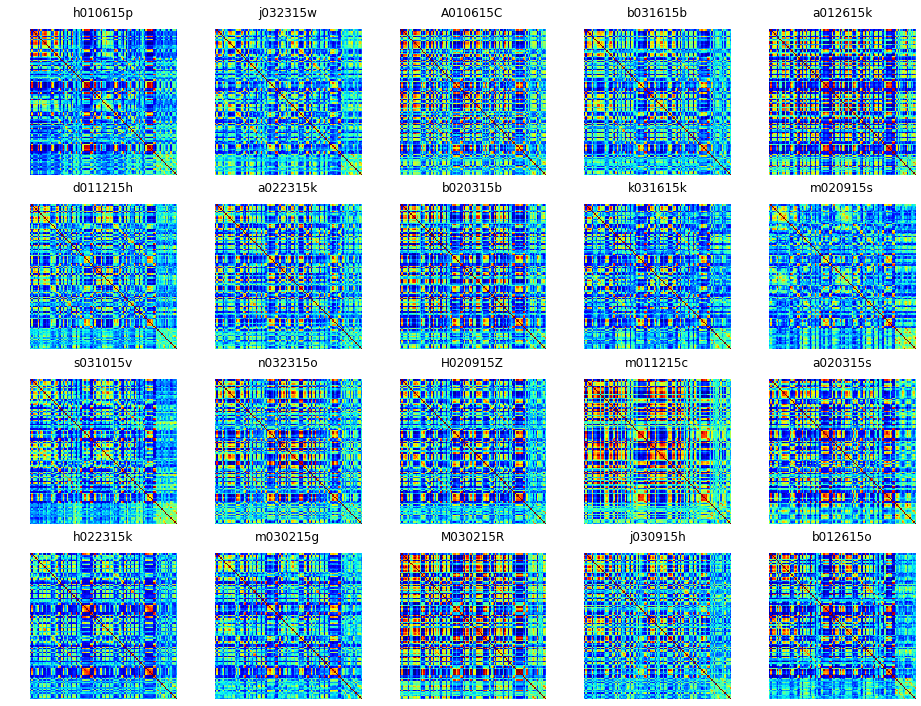

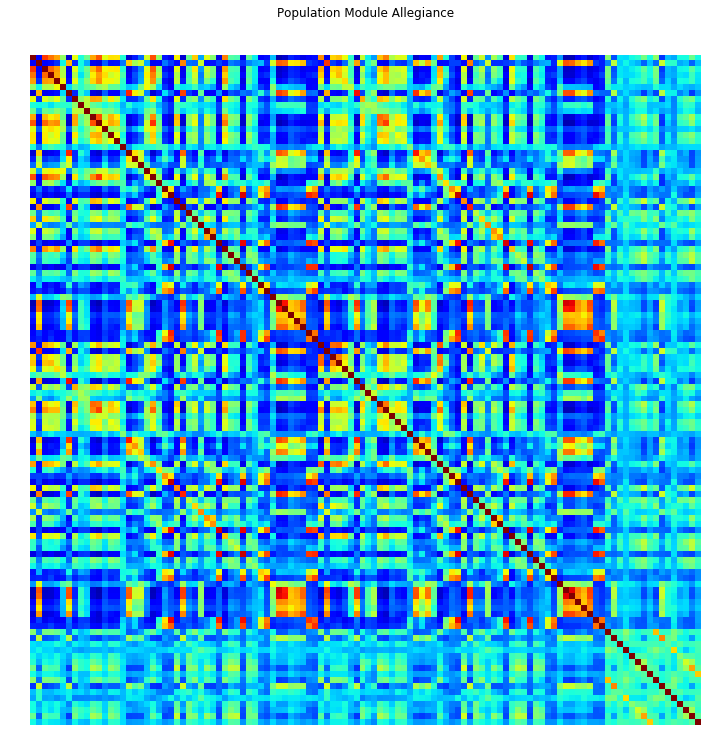

In [3]:
%matplotlib inline

plt.figure(figsize=(16, 12))

n_subj = len(subj_seeds.keys())
n_rows = int(np.sqrt(n_subj))
n_cols = int(np.ceil(n_subj/n_rows))

for ii, (subj, seeds) in enumerate(subj_seeds.items()):
    print(" -- Processing: {}".format(subj))
    
    ax = plt.subplot(n_rows, n_cols, ii+1)
    for ix, path in enumerate(seeds):
        data = np.load(path, mmap_mode='r')
        module_assign = data['module_assign']
        
        n_win = module_assign.shape[0]
        n_node = module_assign.shape[1] 
        
        if (ii == 0) and (ix == 0):
            pop_module_alleg = np.zeros((n_node, n_node))
        if ix == 0:
            subj_module_alleg = np.zeros((n_node, n_node))
            
        for iw in xrange(n_win):
            module_id = np.unique(module_assign[iw, :])
            
            for m_id in module_id:
                m_nodes = np.flatnonzero(module_assign[iw, :] == m_id)
                n1, n2 = np.meshgrid(m_nodes, m_nodes)
                
                subj_module_alleg[n1, n2] += 1
                pop_module_alleg[n1, n2] += 1

    # Subject-level Module Allegiance
    subj_module_alleg /= subj_module_alleg[0, 0]
    ax.matshow(subj_module_alleg, vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title(subj)

# Population-level Module Allegiance
pop_module_alleg /= pop_module_alleg[0, 0]
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax.matshow(pop_module_alleg, vmin=0, vmax=1)
ax.set_axis_off()
ax.set_title('Population Module Allegiance')


## Temporal Allegiance

How often do time windows occupy the same functional module?

 -- Processing: h010615p
 -- Processing: j032315w
 -- Processing: A010615C
 -- Processing: b031615b
 -- Processing: a012615k
 -- Processing: d011215h
 -- Processing: a022315k
 -- Processing: b020315b
 -- Processing: k031615k
 -- Processing: m020915s
 -- Processing: s031015v
 -- Processing: n032315o
 -- Processing: H020915Z
 -- Processing: m011215c
 -- Processing: a020315s
 -- Processing: h022315k
 -- Processing: m030215g
 -- Processing: M030215R
 -- Processing: j030915h
 -- Processing: b012615o


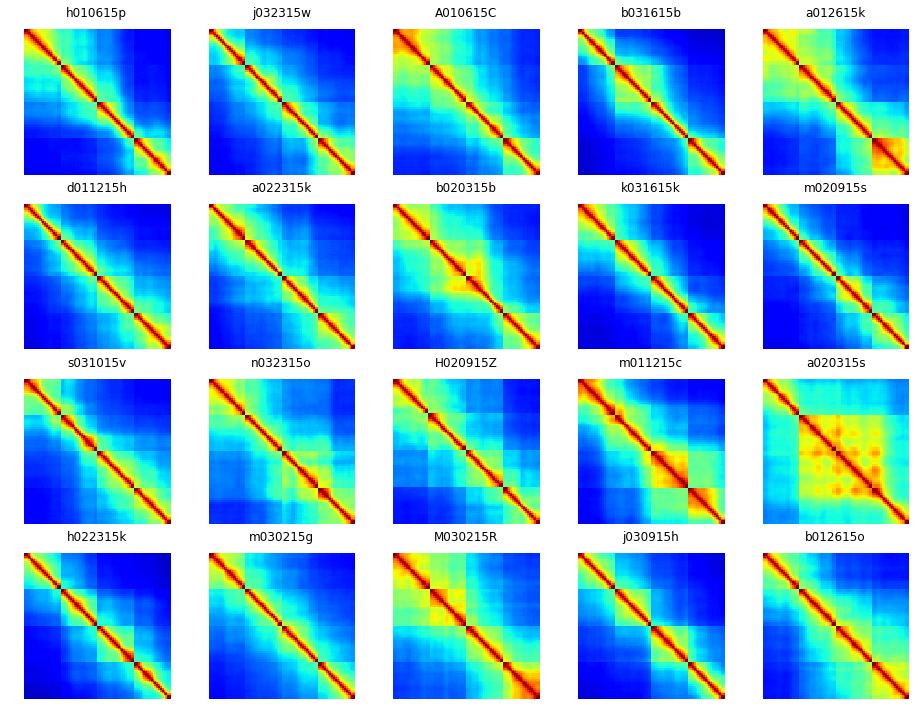

In [ ]:
%matplotlib inline


plt.figure(figsize=(16, 12))

n_subj = len(subj_seeds.keys())
n_rows = int(np.sqrt(n_subj))
n_cols = int(np.ceil(n_subj/n_rows))

for ii, (subj, seeds) in enumerate(subj_seeds.items()):
    print(" -- Processing: {}".format(subj))
    
    ax = plt.subplot(n_rows, n_cols, ii+1)
    for ix, path in enumerate(seeds):
        data = np.load(path, mmap_mode='r')
        module_assign = data['module_assign']
        
        n_win = module_assign.shape[0]
        n_node = module_assign.shape[1] 
        
        if ix == 0:
            subj_module_alleg = np.zeros((n_win, n_win))
            
        for iw in xrange(n_node):
            module_id = np.unique(module_assign[:, iw])
            
            for m_id in module_id:
                m_win = np.flatnonzero(module_assign[:, iw] == m_id)
                w1, w2 = np.meshgrid(m_win, m_win)
                
                subj_module_alleg[w1, w2] += 1

    # Subject-level Module Allegiance
    subj_module_alleg /= subj_module_alleg[0, 0]
    ax.matshow(subj_module_alleg, vmin=0, vmax=1)
    ax.set_axis_off()
    ax.set_title(subj)

## Consensus Dynamic Modules

In [ ]:
for ii, (subj, seeds) in enumerate(subj_seeds.items()):
    print(" -- Processing: {}".format(subj))
    
    # Dynamic Module Allegiance
    for ix, path in enumerate(seeds):
        data = np.load(path, mmap_mode='r')
        module_assign = data['module_assign'][...]

        n_win = module_assign.shape[0]
        n_node = module_assign.shape[1]
        
        if ix==0:
            subj_dynmod_alleg = np.zeros((n_win*n_node, n_win*n_node))

        dynmod_assign = module_assign.reshape(-1)    
        module_id = np.unique(dynmod_assign)            
        for m_id in module_id:
            m_nodes = np.flatnonzero(dynmod_assign == m_id)
            n1, n2 = np.meshgrid(m_nodes, m_nodes)

            subj_dynmod_alleg[n1, n2] += 1 
    subj_dynmod_alleg /= subj_dynmod_alleg[0, 0]
    subj_dynmod_alleg[np.diag_indices_from(subj_dynmod_alleg)] = 0
    
    # Compute Static Modularity
    k = np.sum(subj_dynmod_alleg, axis=0)
    twom = np.sum(k)
    B = subj_dynmod_alleg - np.dot(k.reshape(-1, 1), k.reshape(1, -1)) / twom
    
    cvec, q = Codebase.Networks.ModuleDetection.community.genlouvain(B,
                                                                     limit=1000,
                                                                     verbose=True)
    
    # Cache the community detection result
    np.savez("{}/{}.consensus_module.npz".format(path_ExpData, subj),
             module_assign=cvec.reshape(n_win, n_node)) 

 -- Processing: h010615p


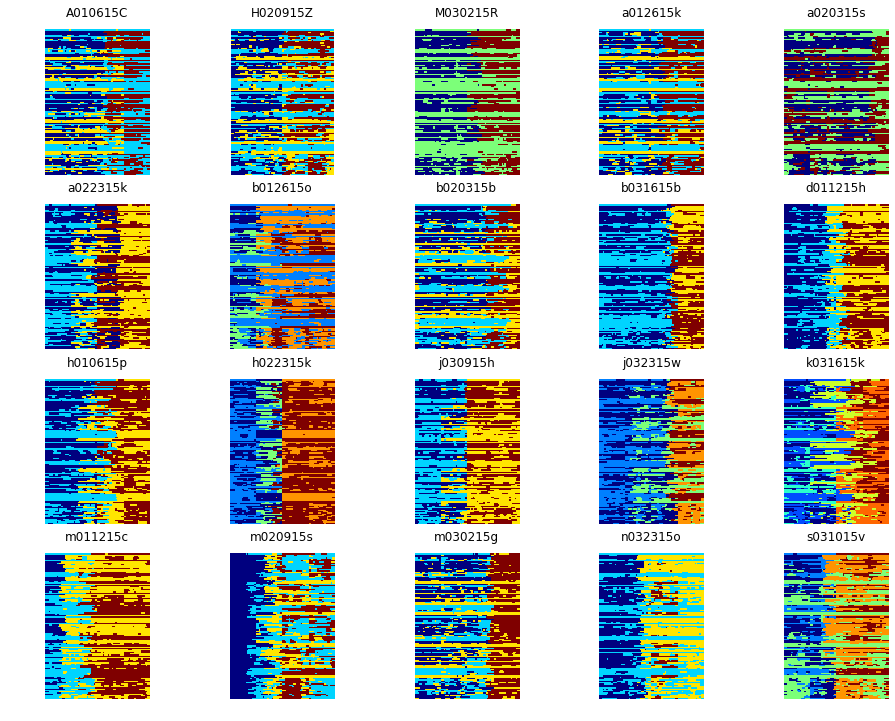

In [10]:
n_subj = len(subj_ids)
n_row = int(np.sqrt(n_subj))
n_col = int(np.ceil(n_subj/n_row))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(n_subj):
    data = np.load("{}/{}.consensus_module.npz".format(path_ExpData,
                                                       subj_ids[ii]))
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(data['module_assign'].T)
    ax.set_axis_off()
    ax.set_xlabel('Windows')
    ax.set_ylabel('Brain Regions')
    ax.set_title(subj_ids[ii])